In [2]:
from urllib.request import urlopen
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture

In [3]:
data = pd.read_csv(urlopen("https://raw.githubusercontent.com/cyndoro/CloudMonitoringDataset/main/Dataset.csv"))
data.head()

,Microservices,CPU,mem,response,throughtput,timestamp
0,bookshop-ui,36.8,291,5.561,9.467,07/07/2020 17:19
1,bookshop-books,34.6,4297,6.485,22.000,07/07/2020 17:19
2,bookshop-purchases,36.0,585,8.686,9.367,07/07/2020 17:19
3,bookshop-ui,36.2,291,13.550,9.267,07/07/2020 17:19
4,bookshop-books,36.2,4298,2.877,16.710,07/07/2020 17:20


In [ ]:
#%pip install openpyxl
#data = pd.read_excel("../input/anamaly/Dataset (1) (2).xlsx", engine="openpyxl")

In [4]:
print(data.shape)

(2726, 6)


In [5]:
data.isnull().sum()

Microservices    0
CPU              0
mem              0
response         0
throughtput      0
timestamp        0
dtype: int64

In [6]:
data.describe().loc[['count','mean','min','max']]

,CPU,mem,response,throughtput
count,2726.000000,2726.000000,2726.000000,2726.000000
mean,52.840609,1999.463683,957.256865,44.997053
min,0.600000,215.000000,0.002000,0.033000
max,94.100000,4575.000000,27750.000000,415.660000


In [7]:
dataframe = pd.DataFrame(data)

In [8]:
newDf = dataframe.drop(["timestamp"], axis=1)
newDf

,Microservices,CPU,mem,response,throughtput
0,bookshop-ui,36.8,291,5.561,9.467
1,bookshop-books,34.6,4297,6.485,22.000
2,bookshop-purchases,36.0,585,8.686,9.367
3,bookshop-ui,36.2,291,13.550,9.267
4,bookshop-books,36.2,4298,2.877,16.710
...,...,...,...,...,...
2721,bookshop-purchases,26.8,693,67.210,0.167
2722,bookshop-books,26.8,4299,1017.000,0.433
2723,bookshop-ui,28.5,347,3796.000,0.033
2724,bookshop-purchases,28.5,693,4.500,0.033


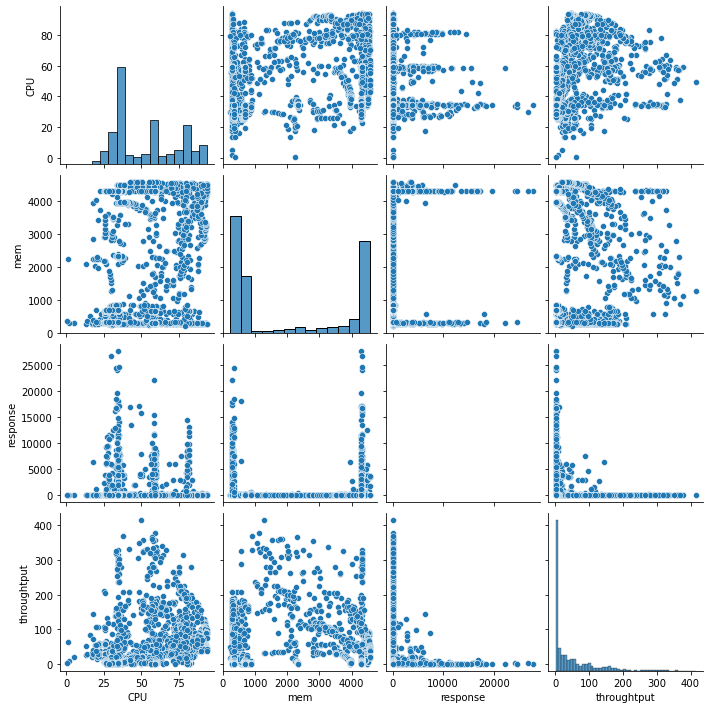

In [9]:
sns.pairplot(newDf)

In [10]:
def param_hist(param, thresh):
    x = newDf[param]
    _, _, bars = plt.hist(x, bins = 10, color="C0")
    for bar in bars:
      if param != "throughtput":
        if bar.get_x() > thresh:
            bar.set_facecolor("C1")
      else:
        if bar.get_x() < thresh:
          bar.set_facecolor("C1")
    plt.xlabel(param)
    plt.ylabel("Count")
    plt.show()

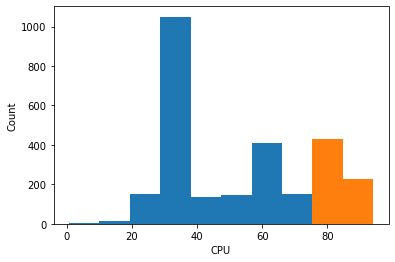

In [11]:
param_hist("CPU", 70)

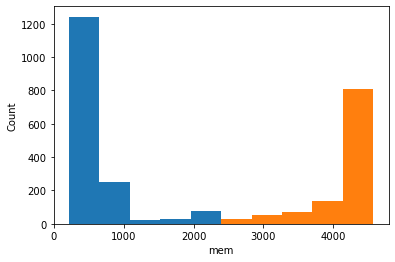

In [12]:
param_hist("mem", 2000)

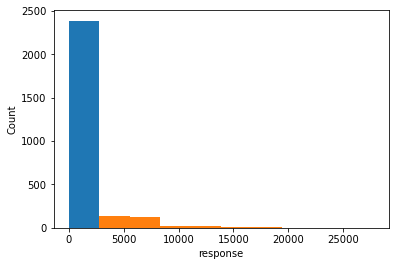

In [13]:
param_hist("response", 2000)

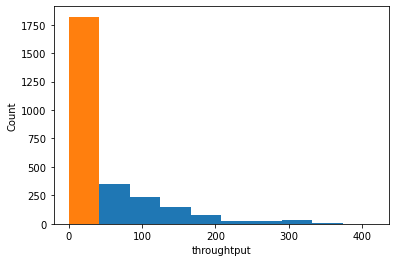

In [14]:
param_hist("throughtput", 25)

Labeling anomalies for CPU, Mem, Response, Throughtput Respectively

In [38]:
#Data discretization 
#label = pd.cut(newDf.CPU,bins=[0,70,99],labels=['0','1'])
#newDf.insert(2,'cpuCluster',label)

In [ ]:
# display updated newDf
#newDf.head()

In [15]:
def Labeling(conName, param, thresh, clusName):
    if param != 'throughtput':
        # create a list of conditions
        conName = [(newDf[param] <= thresh),(newDf[param] > thresh)]
    else:
        conName = [(newDf[param] >= thresh),(newDf[param] < thresh)]

    # create a list of the values we want to assign for each condition
    values = ['0', '1']

    # create a new column and use np.select to assign values to it using our lists as arguments
    newDf[clusName] = np.select(conName, values)

In [16]:
Labeling('tConditioncpu', 'CPU', 70, 'cpuCluster')
Labeling('tConditionmem', 'mem', 2000, 'memCluster')
Labeling('tConditionres', 'response', 2000, 'resCluster')
Labeling('tConditiontp', 'throughtput', 25, 'tpCluster')

In [17]:
newDf

,Microservices,CPU,mem,response,throughtput,cpuCluster,memCluster,resCluster,tpCluster
0,bookshop-ui,36.8,291,5.561,9.467,0,0,0,1
1,bookshop-books,34.6,4297,6.485,22.000,0,1,0,1
2,bookshop-purchases,36.0,585,8.686,9.367,0,0,0,1
3,bookshop-ui,36.2,291,13.550,9.267,0,0,0,1
4,bookshop-books,36.2,4298,2.877,16.710,0,1,0,1
...,...,...,...,...,...,...,...,...,...
2721,bookshop-purchases,26.8,693,67.210,0.167,0,0,0,1
2722,bookshop-books,26.8,4299,1017.000,0.433,0,1,0,1
2723,bookshop-ui,28.5,347,3796.000,0.033,0,0,1,1
2724,bookshop-purchases,28.5,693,4.500,0.033,0,0,0,1


In [18]:
freqLabel = newDf.iloc[:, 5].value_counts(normalize=True)
freqLabel

0    0.717535
1    0.282465
Name: cpuCluster, dtype: float64

In [ ]:
#newDf.to_csv(r'C:\Users\Cynthia\Downloads\AnomalyDetection.csv', index=False)
newDf

User defined Functions for Models

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier


In [20]:
X = newDf.iloc[:, 1].values
y = newDf.iloc[:, 5].values

#Spliting the dataset into Training set and Test Set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=0)

In [21]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2180,)
(546,)
(2180,)
(546,)


In [22]:
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
import seaborn as sns
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,roc_curve,roc_auc_score


In [23]:
X_train= X_train.reshape(-1, 1)
X_test = X_test.reshape(-1, 1)
print(X_train.shape)
print(X_test.shape)

(2180, 1)
(546, 1)


In [24]:
def evaluate_model(model, X_test, y_test):
    from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, cohen_kappa_score, confusion_matrix, roc_auc_score, roc_curve

    # Predict Test Data 
    y_pred = model.predict(X_test)

    # Calculate accuracy, precision, recall, f1-score, and kappa score
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred,pos_label='0', average="binary")
    rec = recall_score(y_test, y_pred,pos_label='1', average="binary")
    f1 = f1_score(y_test, y_pred,pos_label='1')
    kappa = cohen_kappa_score(y_test, y_pred)

    # Calculate area under curve (AUC)
    y_pred_proba = model.predict_proba(X_test)[::,1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba, pos_label='1')
    auc = roc_auc_score(y_test, y_pred_proba)

    # Display confussion matrix
    cm = confusion_matrix(y_test, y_pred)

    return {'acc': acc,  'kappa': kappa, 'prec':prec, 'rec':rec, 'f1':f1,
            'fpr': fpr, 'tpr': tpr, 'auc': auc, 'cm': cm}

In [25]:
gnb_clf = GaussianNB().fit(X_train,y_train)
gnb_predictions = gnb_clf.predict(X_test)

print("Train Results")
# Evaluate Model
gnb_eval = evaluate_model(gnb_clf, X_test, y_test)

# Print result
print('Accuracy:', gnb_eval['acc'])
print('Precision:', gnb_eval['prec'])
print('Recall:', gnb_eval['rec'])
print('F1 Score:', gnb_eval['f1'])
print('Cohens Kappa Score:', gnb_eval['kappa'])
print('Area Under Curve:', gnb_eval['auc'])
print('Confusion Matrix:\n', gnb_eval['cm'])

Train Results
Accuracy: 0.9926739926739927
Precision: 1.0
Recall: 1.0
F1 Score: 0.9852941176470589
Cohens Kappa Score: 0.9804174736389069
Area Under Curve: 1.0
Confusion Matrix:
 [[408   4]
 [  0 134]]


In [26]:
y_train_pred = gnb_clf.predict(X_train)
y_test_pred = gnb_clf.predict(X_test)
print(confusion_matrix(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))

[[1532   12]
 [   0  636]]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1544
           1       0.98      1.00      0.99       636

    accuracy                           0.99      2180
   macro avg       0.99      1.00      0.99      2180
weighted avg       0.99      0.99      0.99      2180



## Random Forest Classifier

In [27]:
#Building Random Forest Model
rf_clf = RandomForestClassifier(n_estimators = 50,max_depth = 20,
                                random_state=345, verbose = 1)
rf_clf.fit(X_train, y_train)

print("Train Results")
# Evaluate Model
rf_eval = evaluate_model(rf_clf, X_test, y_test)

# Print result
print('Accuracy:', rf_eval['acc'])
print('Precision:', rf_eval['prec'])
print('Recall:', rf_eval['rec'])
print('F1 Score:', rf_eval['f1'])
print('Cohens Kappa Score:', rf_eval['kappa'])
print('Area Under Curve:', rf_eval['auc'])
print('Confusion Matrix:\n', rf_eval['cm'])

Train Results
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Cohens Kappa Score: 1.0
Area Under Curve: 1.0
Confusion Matrix:
 [[412   0]
 [  0 134]]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


In [28]:
y_train_pred = rf_clf.predict(X_train)
y_test_pred = rf_clf.predict(X_test)
print(confusion_matrix(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))

[[1544    0]
 [   0  636]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1544
           1       1.00      1.00      1.00       636

    accuracy                           1.00      2180
   macro avg       1.00      1.00      1.00      2180
weighted avg       1.00      1.00      1.00      2180



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


## Decission Tree Classifier

In [31]:
dt = DecisionTreeClassifier(criterion = 'entropy',random_state=0,max_depth = 6)
dt.fit(X_train, y_train)
# Evaluate Model
dt_eval = evaluate_model(dt, X_test, y_test)

# Print result
print('Accuracy:', dt_eval['acc'])
print('Cohens Kappa Score:', dt_eval['kappa'])
print('Area Under Curve:', dt_eval['auc'])
print('Confusion Matrix:\n', dt_eval['cm'])

Accuracy: 1.0
Cohens Kappa Score: 1.0
Area Under Curve: 1.0
Confusion Matrix:
 [[412   0]
 [  0 134]]


In [32]:
y_train_pred = dt.predict(X_train)
y_test_pred = dt.predict(X_test)
print(confusion_matrix(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))

[[1544    0]
 [   0  636]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1544
           1       1.00      1.00      1.00       636

    accuracy                           1.00      2180
   macro avg       1.00      1.00      1.00      2180
weighted avg       1.00      1.00      1.00      2180



## Logistic Regression

In [33]:
lr=LogisticRegression(max_iter=10000)
lr.fit(X_train,y_train)

# Evaluate Model
lr_eval = evaluate_model(lr, X_test, y_test)

# Print result
print('Accuracy:', lr_eval['acc'])
print('Cohens Kappa Score:', lr_eval['kappa'])
print('Area Under Curve:', lr_eval['auc'])
print('Confusion Matrix:\n', lr_eval['cm'])

Accuracy: 1.0
Cohens Kappa Score: 1.0
Area Under Curve: 1.0
Confusion Matrix:
 [[412   0]
 [  0 134]]


In [34]:
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)
print(confusion_matrix(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))

[[1544    0]
 [   0  636]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1544
           1       1.00      1.00      1.00       636

    accuracy                           1.00      2180
   macro avg       1.00      1.00      1.00      2180
weighted avg       1.00      1.00      1.00      2180



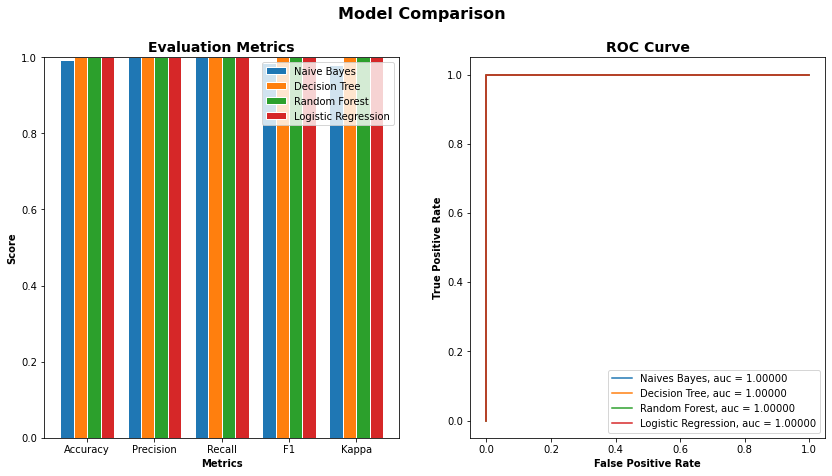

In [35]:
# Intitialize figure with two plots
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Model Comparison', fontsize=16, fontweight='bold')
fig.set_figheight(7)
fig.set_figwidth(14)
fig.set_facecolor('white')

# First plot
## set bar size
barWidth = 0.2
gnb_score = [gnb_eval['acc'], gnb_eval['prec'], gnb_eval['rec'], gnb_eval['f1'], gnb_eval['kappa']]
dtc_score = [dt_eval['acc'], dt_eval['prec'], dt_eval['rec'], dt_eval['f1'], dt_eval['kappa']]
rf_score = [rf_eval['acc'], rf_eval['prec'], rf_eval['rec'], rf_eval['f1'], rf_eval['kappa']]
lr_score = [lr_eval['acc'], lr_eval['prec'], lr_eval['rec'], lr_eval['f1'], lr_eval['kappa']]


## Set position of bar on X axis
r1 = np.arange(len(gnb_score))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]


## Make the plot
ax1.bar(r1, gnb_score, width=barWidth, edgecolor='white', label='Naive Bayes')
ax1.bar(r2, dtc_score, width=barWidth, edgecolor='white', label='Decision Tree')
ax1.bar(r3, rf_score, width=barWidth, edgecolor='white', label='Random Forest')
ax1.bar(r4, lr_score, width=barWidth, edgecolor='white', label='Logistic Regression')



## Configure x and y axis
ax1.set_xlabel('Metrics', fontweight='bold')
labels = ['Accuracy', 'Precision', 'Recall', 'F1', 'Kappa']
ax1.set_xticks([r + (barWidth * 1.5) for r in range(len(dtc_score))], )
ax1.set_xticklabels(labels)
ax1.set_ylabel('Score', fontweight='bold')
ax1.set_ylim(0, 1)

## Create legend & title
ax1.set_title('Evaluation Metrics', fontsize=14, fontweight='bold')
ax1.legend()

# Second plot
## Comparing ROC Curve
ax2.plot(gnb_eval['fpr'], gnb_eval['tpr'], label='Naives Bayes, auc = {:0.5f}'.format(gnb_eval['auc']))
ax2.plot(dt_eval['fpr'], dt_eval['tpr'], label='Decision Tree, auc = {:0.5f}'.format(dt_eval['auc']))
ax2.plot(rf_eval['fpr'], rf_eval['tpr'], label='Random Forest, auc = {:0.5f}'.format(rf_eval['auc']))
ax2.plot(lr_eval['fpr'], lr_eval['tpr'], label='Logistic Regression, auc = {:0.5f}'.format(lr_eval['auc']))


## Configure x and y axis
ax2.set_xlabel('False Positive Rate', fontweight='bold')
ax2.set_ylabel('True Positive Rate', fontweight='bold')

## Create legend & title
ax2.set_title('ROC Curve', fontsize=14, fontweight='bold')
ax2.legend(loc=4)

plt.show()